In [1]:
# Install required libraries for fine-tuning
!pip install protobuf==3.20.3
!pip install -q git+https://github.com/huggingface/peft.git transformers bitsandbytes accelerate datasets evaluate

import os
import torch
import json 
import pandas as pd
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from transformers import Blip2Processor, Blip2ForConditionalGeneration
from peft import LoraConfig, get_peft_model
from tqdm import tqdm
import evaluate
import matplotlib.pyplot as plt
import nltk
from nltk.translate.bleu_score import sentence_bleu

nltk.download('punkt', quiet=True)

# ==========================================
# Setup & Configuration
# ==========================================
def seed_everything(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(42)
device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_DIR = '/kaggle/input/vqa-rad-visual-question-answering-radiology'
JSON_PATH = os.path.join(BASE_DIR, 'VQA_RAD Dataset Public.json')
IMAGE_DIR = os.path.join(BASE_DIR, 'VQA_RAD Image Folder')

# Hyperparameters
BATCH_SIZE = 4  
EPOCHS = 5     
LEARNING_RATE = 1e-5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.1/162.1 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 6.33.0
    Uninstalling protobuf-6.33.0:
      Successfully uninstalled protobuf-6.33.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
bigframes 2.12.0 requires google-cloud-bigquery-storage<3.0.0,>=2.30.0, which is not installed.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 3.20.3 which is incompatible.
onnx 1.18.0 requires protobuf>=4.25.1, but you have protobuf 3.20.3 which is incompatible.
a2a-sdk 0.3.10 requires protobuf>=5.29.5, but you have protobuf 3.20.3 which is incompatible.
ray 2.51.1 requires click!=8.3.0,>=7.0, but you have click 8.3.0 which is incompatible.
bigframes 2.12.0 requires rich<14,>=12.4.4, but you have rich 14.2.0 which is incompatible.
tensorflow-me

2026-01-14 02:17:28.819873: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768357049.001264      47 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768357049.055683      47 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# ==========================================
# Dataset for Generative VQA
# ==========================================
class VQAGenerativeDataset(Dataset):
    def __init__(self, df, img_dir, processor):
        self.df = df
        self.img_dir = img_dir
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_name = row['image_name']
        question = row['question']
        
        # Get answer
        answer = str(row['answer']).lower().strip()

        # Load image
        img_path = os.path.join(self.img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            image = Image.new('RGB', (224, 224))

        # Define prompt
        prompt = f"Question: {question} Answer:"
        if row.get('answer_type') == 'CLOSED':
             prompt = f"Question: {question} Answer yes or no."

        # Define full text (Prompt + Answer + EOS)
        eos = self.processor.tokenizer.eos_token
        full_text = prompt + " " + answer + eos
        
        # Tokenize full text (training target)
        inputs = self.processor(
            images=image,
            text=full_text,
            return_tensors="pt",
            padding="max_length", 
            truncation=True,
            max_length=128        
        )
        
        # Tokenize prompt only (for mask length calculation)
        prompt_inputs = self.processor(
            images=image,
            text=prompt,
            return_tensors="pt",
        )

        input_ids = inputs.input_ids.squeeze(0)
        labels = input_ids.clone()

        # Masking: Set prompt part to -100
        prompt_len = prompt_inputs.input_ids.shape[1]
        if prompt_len < labels.shape[0]:
            labels[:prompt_len] = -100
        
        # Set padding part to -100
        labels[input_ids == self.processor.tokenizer.pad_token_id] = -100

        return {
            "pixel_values": inputs.pixel_values.squeeze(0),
            "input_ids": input_ids,
            "attention_mask": inputs.attention_mask.squeeze(0),
            "labels": labels
        }

# Collate function to handle variable length in batch
def collate_fn(batch):
    pixel_values = torch.stack([item["pixel_values"] for item in batch])
    
    # Pad input_ids and attention_mask
    input_ids = torch.nn.utils.rnn.pad_sequence(
        [item["input_ids"] for item in batch], batch_first=True, padding_value=processor.tokenizer.pad_token_id
    )
    attention_mask = torch.nn.utils.rnn.pad_sequence(
        [item["attention_mask"] for item in batch], batch_first=True, padding_value=0
    )
    
    # Pad labels (use -100 to ignore padding in loss calculation)
    labels = torch.nn.utils.rnn.pad_sequence(
        [item["labels"] for item in batch], batch_first=True, padding_value=-100
    )
    
    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }

# Prepare data
with open(JSON_PATH, 'r') as f:
    df = pd.DataFrame(json.load(f))

# Data cleaning
df['question'] = df['question'].astype(str)
df['answer'] = df['answer'].astype(str)

# ==========================================
# Split by Image ID (ensure same image in one set)
# ==========================================
from sklearn.model_selection import train_test_split

# Get unique image IDs
unique_img_ids = df['image_name'].unique()

# Split image IDs: 80% train, 20% temp (for val and test)
train_ids, temp_ids = train_test_split(unique_img_ids, test_size=0.2, random_state=42)

# Further split temp: 50% validation, 50% test (from the 20%)
val_ids, test_ids = train_test_split(temp_ids, test_size=0.5, random_state=42)

# Create dataframes based on image IDs
train_df = df[df['image_name'].isin(train_ids)].reset_index(drop=True)
val_df = df[df['image_name'].isin(val_ids)].reset_index(drop=True)

print(f"Total Rows: {len(df)}")
print(f"Train Rows: {len(train_df)} (Images: {len(train_ids)})")
print(f"Val Rows: {len(val_df)} (Images: {len(val_ids)})")

Total Rows: 2248
Train Rows: 1831 (Images: 251)
Val Rows: 210 (Images: 31)


In [3]:
# ==========================================
# Model Setup with LoRA (Fixed for BLIP-2)
# ==========================================
print("Loading BLIP-2 Model in Float16...")

# Load model (use float16 to save GPU memory)
processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", 
    device_map="auto", 
    torch_dtype=torch.float16
)

# Freeze all base model parameters
for param in model.parameters():
    param.requires_grad = False

# Configure LoRA
peft_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "k_proj", "v_proj", "o_proj", "fc1", "fc2"],
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

# Apply PEFT only to language_model to avoid forward pass conflicts
print("Wrapping Language Model with LoRA...")
model.language_model = get_peft_model(model.language_model, peft_config)

# Verify trainable parameters
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
all_params = sum(p.numel() for p in model.parameters())
print(f"Trainable params: {trainable_params} || All params: {all_params} || Trainable%: {100 * trainable_params / all_params:.2f}%")

# Create DataLoaders
train_dataset = VQAGenerativeDataset(train_df, IMAGE_DIR, processor)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn)
val_dataset = VQAGenerativeDataset(val_df, IMAGE_DIR, processor)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


Loading BLIP-2 Model in Float16...


preprocessor_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/882 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/23.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

processor_config.json:   0%|          | 0.00/68.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/10.0G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Wrapping Language Model with LoRA...
Trainable params: 20971520 || All params: 3765733376 || Trainable%: 0.56%


In [4]:
# ==========================================
# Training Loop
# ==========================================
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)

print("Start Fine-tuning...")
model.train()

# Track metrics for visualization
train_losses = []
val_losses = []

for epoch in range(EPOCHS):
    total_loss = 0
    progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}")
    
    for batch in progress_bar:
        # Ensure data is in float16
        pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
        input_ids = batch["input_ids"].to(device)
        labels = batch["labels"].to(device)
        
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(
            pixel_values=pixel_values,
            input_ids=input_ids,
            labels=labels
        )
        
        loss = outputs.loss
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
        progress_bar.set_postfix({"loss": loss.item()})
        
        
    avg_loss = total_loss / len(train_loader)
    train_losses.append(avg_loss)
    print(f"Epoch {epoch+1} Average Loss: {avg_loss:.4f}")
    
    # Validation phase
    model.eval()
    val_total_loss = 0
    
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Epoch {epoch+1} [Val]"):
            pixel_values = batch["pixel_values"].to(device, dtype=torch.float16)
            input_ids = batch["input_ids"].to(device)
            labels = batch["labels"].to(device)
            
            outputs = model(
                pixel_values=pixel_values,
                input_ids=input_ids,
                labels=labels
            )
            
            val_total_loss += outputs.loss.item()
    
    avg_val_loss = val_total_loss / len(val_loader)
    val_losses.append(avg_val_loss)
    
    print(f"Epoch {epoch+1} Val Loss: {avg_val_loss:.4f}")
    
    # Save LoRA weights only (very small)
    model.language_model.save_pretrained(f"blip2_lora_epoch_{epoch+1}")
    model.train()

print("Fine-tuning Finished!")

Start Fine-tuning...


Epoch 1: 100%|██████████| 458/458 [12:06<00:00,  1.59s/it, loss=1.49] 


Epoch 1 Average Loss: 1.8369


Epoch 1 [Val]: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 1 Val Loss: 1.5476


config.json:   0%|          | 0.00/691 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:310: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
Epoch 2: 100%|██████████| 458/458 [12:06<00:00,  1.59s/it, loss=0.196]


Epoch 2 Average Loss: 1.3670


Epoch 2 [Val]: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 2 Val Loss: 1.4333


Epoch 3: 100%|██████████| 458/458 [12:09<00:00,  1.59s/it, loss=1.4]  


Epoch 3 Average Loss: 1.1666


Epoch 3 [Val]: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 3 Val Loss: 1.4037


Epoch 4: 100%|██████████| 458/458 [12:05<00:00,  1.58s/it, loss=1.09] 


Epoch 4 Average Loss: 1.0283


Epoch 4 [Val]: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 4 Val Loss: 1.3809


Epoch 5: 100%|██████████| 458/458 [12:04<00:00,  1.58s/it, loss=1.97]  


Epoch 5 Average Loss: 0.8831


Epoch 5 [Val]: 100%|██████████| 53/53 [00:52<00:00,  1.01it/s]


Epoch 5 Val Loss: 1.3805
Fine-tuning Finished!


In [7]:
import numpy as np
# ==========================================
# Final Evaluation
# ==========================================
import string
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
from rouge_score import rouge_scorer
from sklearn.metrics import precision_recall_fscore_support

# Load metrics
bleu_metric = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

def clean_text(text):
    """Clean text for comparison"""
    text = str(text).lower().strip()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

def clean_prediction(text):
    """Clean model predictions"""
    text = str(text).lower().strip()
    
    # Handle "question: ... answer: ..." format
    if "answer:" in text:
        text = text.split("answer:")[-1].strip()
    
    # Handle repeated "yesyesyes"
    if text.startswith("yesyes"):
        return "yes"
    # Handle repeated "nonono"
    if text.startswith("nono"):
        return "no"
        
    return text

def evaluate_model_final(model, df, img_dir):
    """Run inference and collect results"""
    model.eval()
    results = []
    print("Running Inference...")
    
    for idx, row in tqdm(df.iterrows(), total=len(df)):
        img_name = row['image_name']
        question = row['question']
        gt_answer = str(row['answer']).lower().strip()
        ans_type = row['answer_type']
        
        img_path = os.path.join(img_dir, img_name)
        try:
            image = Image.open(img_path).convert('RGB')
        except:
            continue
        
        # Keep prompt consistent with training
        prompt = f"Question: {question} Answer:"
        if ans_type == 'CLOSED':
             prompt = f"Question: {question} Answer yes or no." 

        inputs = processor(images=image, text=prompt, return_tensors="pt").to(device, dtype=torch.float16)
        
        with torch.no_grad():
            generated_ids = model.generate(
                **inputs,
                max_new_tokens=20,
                min_length=1,
                do_sample=False,
                num_beams=5,
                repetition_penalty=2.0,
                length_penalty=1.0,
                early_stopping=True,
                eos_token_id=processor.tokenizer.eos_token_id,
                pad_token_id=processor.tokenizer.pad_token_id
            )
            
            # Extract only newly generated tokens
            input_len = inputs.input_ids.shape[1]
            new_tokens = generated_ids[:, input_len:] 
            
            # Decode and clean
            raw_pred = processor.batch_decode(new_tokens, skip_special_tokens=True)[0]
            pred_answer = clean_prediction(raw_pred)

        results.append({
            "question": question,
            "image_name": img_name,
            "ground_truth": gt_answer,
            "prediction": pred_answer,
            "answer_type": ans_type,
            "is_correct": pred_answer == gt_answer
        })
        
    return pd.DataFrame(results)

# Run evaluation
final_results_df = evaluate_model_final(model, val_df, IMAGE_DIR)

# Add cleaned text columns for detailed comparison
final_results_df['pred_clean'] = final_results_df['prediction'].apply(clean_text)
final_results_df['answer_clean'] = final_results_df['ground_truth'].apply(clean_text)

# ==========================================
# Closed-ended Accuracy 
# ==========================================
closed_mask = final_results_df['answer_type'] == 'CLOSED'
closed_df = final_results_df[closed_mask].copy()

closed_correct = 0
for _, row in closed_df.iterrows():
    pred = row['pred_clean']
    gt = row['answer_clean']
    if gt in pred or pred in gt:
        closed_correct += 1

closed_acc = closed_correct / len(closed_df) if len(closed_df) > 0 else 0.0

valid_answers = ['yes', 'no']

closed_eval_df = closed_df[
    closed_df['answer_clean'].isin(valid_answers) &
    closed_df['pred_clean'].isin(valid_answers)
]

if len(closed_eval_df) > 0:
    y_true = closed_eval_df['answer_clean'].values
    y_pred = closed_eval_df['pred_clean'].values

    precision, recall, f1, _ = precision_recall_fscore_support(
        y_true,
        y_pred,
        labels=['yes', 'no'],
        average='binary',
        pos_label='yes',
        zero_division=0
    )
else:
    precision = recall = f1 = 0.

# ==========================================
# Open-ended Metrics (Accuracy + BLEU + ROUGE)
# ==========================================
open_mask = final_results_df['answer_type'] == 'OPEN'
open_df = final_results_df[open_mask].copy()

open_correct = 0
bleu_scores = []
rouge_l_scores = []

scorer = rouge_scorer.RougeScorer(['rougeL'], use_stemmer=True)
cc = SmoothingFunction()

for _, row in open_df.iterrows():
    pred = row['pred_clean']
    gt = row['answer_clean']

    # --- Accuracy ---
    if gt == pred or (len(gt) > 2 and gt in pred):
        open_correct += 1

    # --- BLEU ---
    ref_tokens = [gt.split()]
    pred_tokens = pred.split()
    if len(pred_tokens) == 0:
        bleu = 0.0
    else:
        bleu = sentence_bleu(
            ref_tokens,
            pred_tokens,
            weights=(0.5, 0.5),
            smoothing_function=cc.method1
        )
    bleu_scores.append(bleu)

    # --- ROUGE-L ---
    rouge_l = scorer.score(gt, pred)['rougeL'].fmeasure
    rouge_l_scores.append(rouge_l)

open_acc = open_correct / len(open_df) if len(open_df) > 0 else 0.0
avg_bleu = np.mean(bleu_scores) if bleu_scores else 0.0
avg_rouge = np.mean(rouge_l_scores) if rouge_l_scores else 0.0

# ==========================================
# Final Report
# ==========================================
print("=" * 60)
print("FINAL EVALUATION REPORT (BLIP-2)")
print("=" * 60)
print(f"Total Samples          : {len(final_results_df)}")
print("-" * 40)
print(f"Closed-ended Accuracy  : {closed_acc * 100:.2f}%")
print(f"Precision              : {precision * 100:.2f}%")
print(f"Recall                 : {recall * 100:.2f}%")
print(f"F1-score               : {f1 * 100:.2f}%")
print("-" * 40)
print(f"Open-ended Accuracy    : {open_acc * 100:.2f}%")
print(f"Open-ended BLEU Score  : {avg_bleu * 100:.2f}")
print(f"Open-ended ROUGE-L     : {avg_rouge * 100:.2f}")
print("=" * 60)

Running Inference...


100%|██████████| 210/210 [02:13<00:00,  1.58it/s]

FINAL EVALUATION REPORT (BLIP-2)
Total Samples          : 210
----------------------------------------
Closed-ended Accuracy  : 57.76%
Precision              : 61.11%
Recall                 : 55.93%
F1-score               : 58.41%
----------------------------------------
Open-ended Accuracy    : 22.34%
Open-ended BLEU Score  : 14.00
Open-ended ROUGE-L     : 32.09


In [8]:
# Show sample open-ended predictions
open_samples = final_results_df[final_results_df['answer_type'] == 'OPEN'].sample(10)
print(open_samples[['question', 'ground_truth', 'prediction']])

                                              question           ground_truth  \
206                     Where are the lesions located?      paratracheal area   
198       What is the small mass near the left kidney?               splenule   
69    What lobe of the brain is the lesion located in?     right frontal lobe   
38   How would you describe the aortopulmonary window?           middle mogul   
147                        What do the masses contain?                    fat   
190        The image has an abnormality located where?           retrocardiac   
72   What is represented by the black parts of the ...                    air   
195  What is filling the soft-tissue density seen i...                    air   
89          What is abnormal about the occipital lobe?  ring enhancing lesion   
200  How can you tell the mass is hemorrhagic and p...               not sure   

                       prediction  
206  right lower lobe of the lung  
198                 cystic lesion  


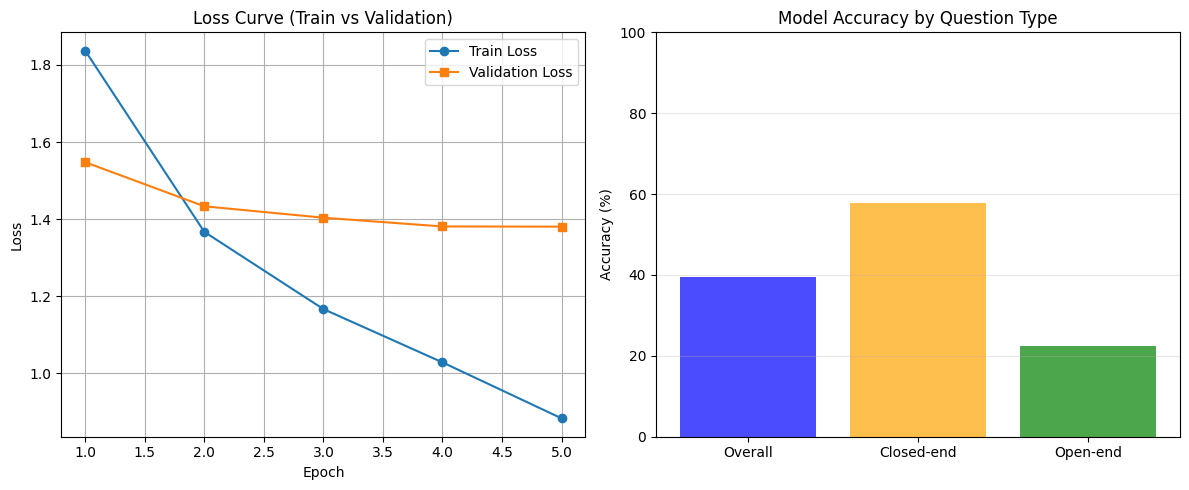

Training curves saved as 'training_curves_blip2.png'


In [9]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), train_losses, marker='o', label='Train Loss')
plt.plot(range(1, EPOCHS+1), val_losses, marker='s', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Curve (Train vs Validation)')
plt.legend()
plt.grid(True)

# Accuracy Curve - Track per epoch
plt.subplot(1, 2, 2)
overall_acc = (final_results_df['is_correct'].sum() / len(final_results_df)) * 100
closed_acc_pct = closed_acc * 100
open_acc_pct = open_acc * 100
plt.bar(['Overall', 'Closed-end', 'Open-end'], [overall_acc, closed_acc_pct, open_acc_pct], color=['blue', 'orange', 'green'], alpha=0.7)
plt.ylabel('Accuracy (%)')
plt.title('Model Accuracy by Question Type')
plt.ylim([0, 100])
plt.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('training_curves_blip2.png', dpi=150, bbox_inches='tight')
plt.show()

print("Training curves saved as 'training_curves_blip2.png'")

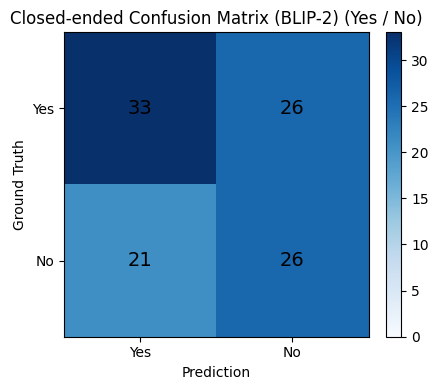

In [10]:
# ==========================================
# Confusion Matrix
# ==========================================
closed_df_cm = final_results_df[final_results_df['answer_type'] == 'CLOSED'].copy()

valid_answers = ['yes', 'no']
closed_df_cm = closed_df_cm[
    closed_df_cm['answer_clean'].isin(valid_answers) &
    closed_df_cm['pred_clean'].isin(valid_answers)
]

cm = np.zeros((2, 2), dtype=int)

label_to_idx = {'yes': 0, 'no': 1}

for _, row in closed_df_cm.iterrows():
    gt_idx = label_to_idx[row['answer_clean']]
    pred_idx = label_to_idx[row['pred_clean']]
    cm[gt_idx, pred_idx] += 1

fig, ax = plt.subplots(figsize=(5, 4))

im = ax.imshow(cm, cmap='Blues', vmin=0, vmax=np.max(cm))

ax.set_xticks([0, 1])
ax.set_yticks([0, 1])
ax.set_xticklabels(['Yes', 'No'])
ax.set_yticklabels(['Yes', 'No'])

ax.set_xlabel("Prediction")
ax.set_ylabel("Ground Truth")
ax.set_title("Closed-ended Confusion Matrix (BLIP-2) (Yes / No)")

for i in range(2):
    for j in range(2):
        ax.text(j, i, cm[i, j], ha='center', va='center', fontsize=14, color='black')

plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


Correct Prediction Examples (BLIP-2)


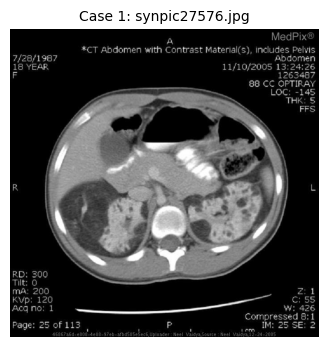

▶ Case 1 ( Correct)
  • Question     : Is there any hemorrhage seen within the kidneys?
  • Ground Truth : no
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


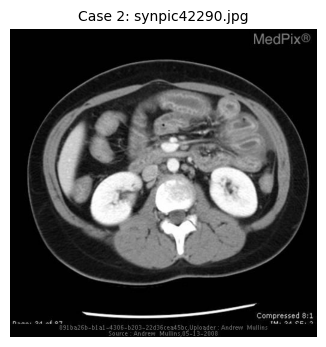

▶ Case 2 ( Correct)
  • Question     : Is there thickening of the jejunum
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


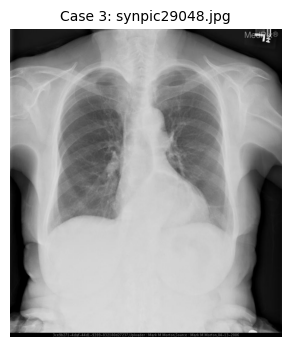

▶ Case 3 ( Correct)
  • Question     : What part of the body does this radiograph show?
  • Ground Truth : chest
  • Prediction   : chest
  • Answer Type  : OPEN
------------------------------------------------------------


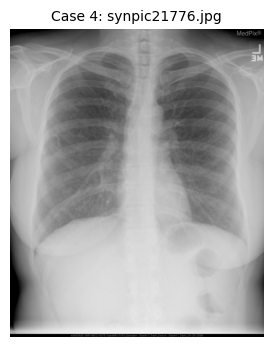

▶ Case 4 ( Correct)
  • Question     : Are >12 ribs present in the image?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


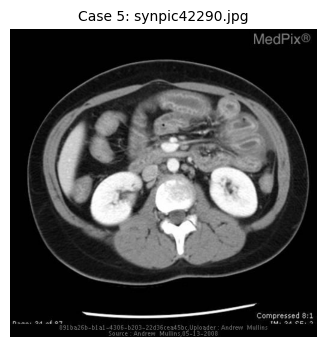

▶ Case 5 ( Correct)
  • Question     : Does this image use GI contrast?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


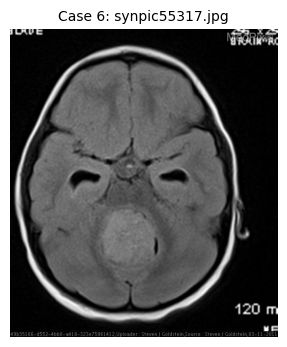

▶ Case 6 ( Correct)
  • Question     : Does this image display the CNS?
  • Ground Truth : yes
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


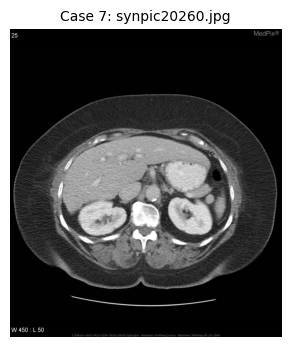

▶ Case 7 ( Correct)
  • Question     : What does nodular liver suggest?
  • Ground Truth : cirrhosis
  • Prediction   : cirrhosis
  • Answer Type  : OPEN
------------------------------------------------------------


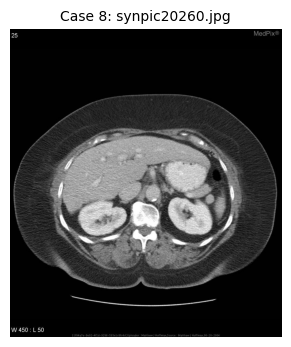

▶ Case 8 ( Correct)
  • Question     : What kind of scan is this?
  • Ground Truth : ct
  • Prediction   : ct
  • Answer Type  : OPEN
------------------------------------------------------------


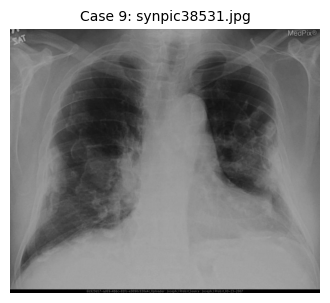

▶ Case 9 ( Correct)
  • Question     : Are the pleural opacities bilateral or unilateral?
  • Ground Truth : bilateral
  • Prediction   : bilateral
  • Answer Type  : CLOSED
------------------------------------------------------------


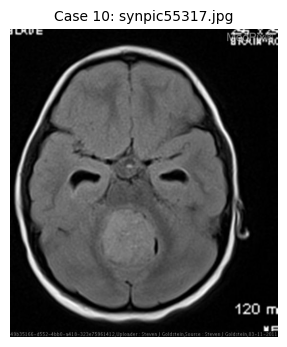

▶ Case 10 ( Correct)
  • Question     : In what plane is this MRI taken?
  • Ground Truth : axial
  • Prediction   : axial
  • Answer Type  : OPEN
------------------------------------------------------------

Incorrect Prediction Examples (BLIP-2)


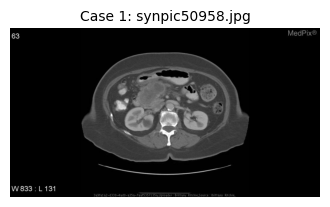

▶ Case 1 ( Incorrect)
  • Question     : What radiographic sign is seen in the intestines
  • Ground Truth : air fluid level
  • Prediction   : diverticuli
  • Answer Type  : OPEN
------------------------------------------------------------


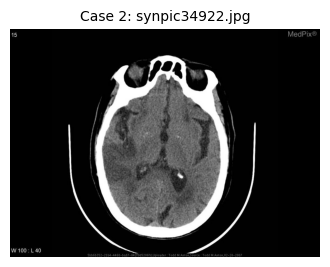

▶ Case 2 ( Incorrect)
  • Question     : Is there any lesion in the ventricles?
  • Ground Truth : yes
  • Prediction   : no
  • Answer Type  : CLOSED
------------------------------------------------------------


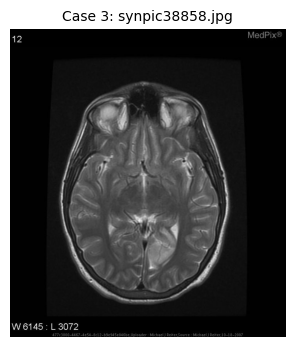

▶ Case 3 ( Incorrect)
  • Question     : Which lobe of the brain demonstrates a hyper-intense signal in this T2 weighted MRI image?
  • Ground Truth : the left occipital lobe
  • Prediction   : right parietal lobe
  • Answer Type  : OPEN
------------------------------------------------------------


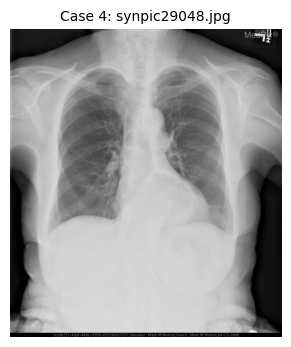

▶ Case 4 ( Incorrect)
  • Question     : The image has an abnormality located where?
  • Ground Truth : retrocardiac
  • Prediction   : right lower lobe of the lung
  • Answer Type  : OPEN
------------------------------------------------------------


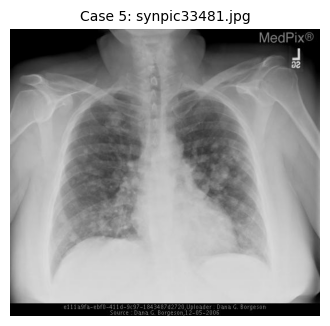

▶ Case 5 ( Incorrect)
  • Question     : Is the aortic knob widened?
  • Ground Truth : no
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


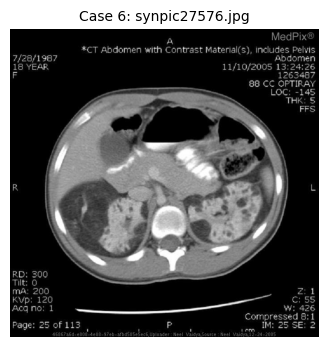

▶ Case 6 ( Incorrect)
  • Question     : Which organ has multiple lesions?
  • Ground Truth : kidneys
  • Prediction   : the liver
  • Answer Type  : OPEN
------------------------------------------------------------


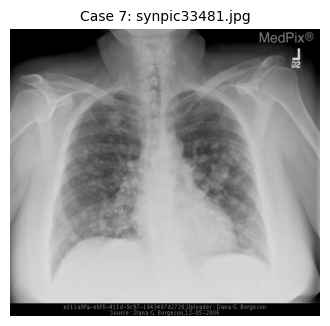

▶ Case 7 ( Incorrect)
  • Question     : Is the diaphragm flattened on either side
  • Ground Truth : no
  • Prediction   : yes
  • Answer Type  : CLOSED
------------------------------------------------------------


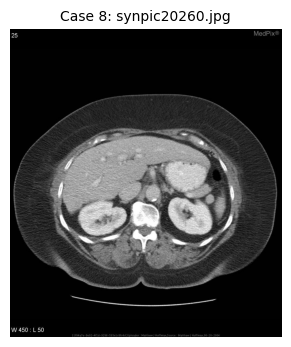

▶ Case 8 ( Incorrect)
  • Question     : What is the brightness in the abdominal aorta?
  • Ground Truth : atherosclerotic calcification
  • Prediction   : calcification
  • Answer Type  : OPEN
------------------------------------------------------------


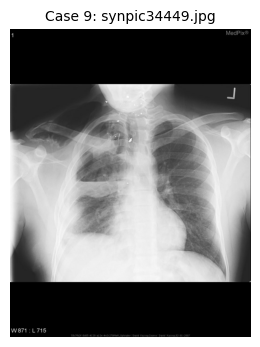

▶ Case 9 ( Incorrect)
  • Question     : Which lung is clearer?
  • Ground Truth : left
  • Prediction   : right
  • Answer Type  : OPEN
------------------------------------------------------------


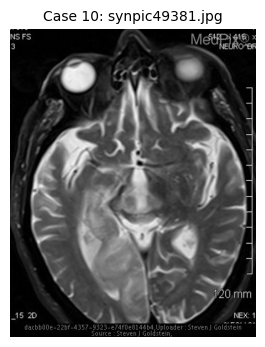

▶ Case 10 ( Incorrect)
  • Question     : Is the brain atrophied or shrunk?
  • Ground Truth : no
  • Prediction   : shrunken
  • Answer Type  : CLOSED
------------------------------------------------------------


In [11]:
# ==========================================
# Visualization Function
# ==========================================
def visualize_vqa_point_form(df, img_dir, title, num_samples=3):
    if len(df) == 0:
        print(f"No samples found for: {title}")
        return

    samples = df.sample(min(num_samples, len(df)))

    print(f"\n{title}")
    print("=" * len(title))

    for i, (_, row) in enumerate(samples.iterrows(), 1):
        img_path = os.path.join(img_dir, row['image_name'])

        plt.figure(figsize=(4, 4))
        try:
            img = Image.open(img_path).convert("RGB")
            plt.imshow(img)
            plt.title(f"Case {i}: {row['image_name']}", fontsize=10)
        except:
            plt.text(0.5, 0.5, "Image Not Found", ha='center', va='center')
        plt.axis("off")
        plt.show()

        is_correct = row['pred_clean'] == row['answer_clean']
        status = " Correct" if is_correct else " Incorrect"

        print(f"▶ Case {i} ({status})")
        print(f"  • Question     : {row['question']}")
        print(f"  • Ground Truth : {row['ground_truth']}")
        print(f"  • Prediction   : {row['prediction']}")
        print(f"  • Answer Type  : {row['answer_type']}")
        print("-" * 60)


# Visualize Correct Examples
correct_examples = final_results_df[
    final_results_df['pred_clean'] == final_results_df['answer_clean']
]

visualize_vqa_point_form(
    correct_examples,
    IMAGE_DIR,
    "Correct Prediction Examples (BLIP-2)",
    num_samples=10
)

# Visualize Incorrect Examples
incorrect_examples = final_results_df[
    final_results_df['pred_clean'] != final_results_df['answer_clean']
]

visualize_vqa_point_form(
    incorrect_examples,
    IMAGE_DIR,
    "Incorrect Prediction Examples (BLIP-2)",
    num_samples=10
)